# Stock Prediction

In [417]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


def get_stock_data(ticker):
    start = datetime.datetime(2010, 1, 1)
    end = datetime.datetime(2019, 1, 11)

    df = web.DataReader("GOOG", 'yahoo', start, end)            
    return df

df = get_stock_data('GOOG')
df.tail()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-07,1074.000000,1054.760010,1071.500000,1068.390015,1981900.0,1068.390015
2019-01-08,1084.560059,1060.530029,1076.109985,1076.280029,1764900.0,1076.280029
2019-01-09,1082.630005,1066.400024,1081.650024,1074.660034,1199300.0,1074.660034
2019-01-10,1071.150024,1057.709961,1067.660034,1070.329956,1456400.0,1070.329956
2019-01-11,1063.775024,1048.479980,1063.180054,1057.189941,1520800.0,1057.189941


### Build required features for prediction

In [418]:
dfreg = df.loc[:,['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-01-07,1068.390015,1981900.0,1.800840,-0.290246
2019-01-08,1076.280029,1764900.0,2.232693,0.015802
2019-01-09,1074.660034,1199300.0,1.510243,-0.646234
2019-01-10,1070.329956,1456400.0,1.255693,0.250072
2019-01-11,1057.189941,1520800.0,1.446764,-0.563415


In [419]:
import math
import numpy as np
from sklearn import preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'

dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)

X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]

X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]


### Import the Regression models

In [420]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [421]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [422]:
def fit(model):
    model.fit(X_train, y_train)

# Linear regression
linear_reg = LinearRegression(n_jobs=-1)
fit(linear_reg)

# Quadratic Regression 2
poly2_reg = make_pipeline(PolynomialFeatures(2), Ridge())
fit(poly2_reg)

# Quadratic Regression 3
poly3_reg = make_pipeline(PolynomialFeatures(3), Ridge())
fit(poly3_reg)

# Lasso Model
lasso_reg = linear_model.Lasso(alpha=0.1)
fit(lasso_reg)

# Ridge Model
ridge_reg = linear_model.Ridge(alpha=.5)
fit(ridge_reg)

In [423]:
def print_score(model, title):
    score = model.score(X_test, y_test)
    print(title + ' score is :', score)

print_score(linear_reg, 'Linear')
print_score(poly2_reg, 'Polynomial 2')
print_score(poly3_reg, 'Polynomial 3')
print_score(lasso_reg, 'Lasso')
print_score(ridge_reg, 'Ridge')


Linear score is : 0.982629250728847
Polynomial 2 score is : 0.9826632912932987
Polynomial 3 score is : 0.9834886506523546
Lasso score is : 0.982629749264261
Ridge score is : 0.9826292684855766


In [424]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# does a forecast and plots it
def forecast(model, title):
    forecast_set = model.predict(X_lately)
    dfreg['Forecast'] = np.nan
    
    last_date = dfreg.iloc[-1].name
    last_unix = last_date
    next_unix = last_unix + datetime.timedelta(days=1)

    for i in forecast_set:
        next_date = next_unix
        next_unix += datetime.timedelta(days=1)
        dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.title(title)
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

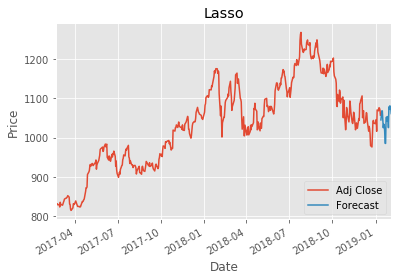

In [425]:
# Plot the one that had highest score
forecast(lasso_reg, 'Lasso')

# Reference
https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7